# Reference
https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/#gan-evaluation--the-frechet-inception-distance-and-inception-score-metrics

## Let's generate images with the model we've created.

First, we'll link the current file to Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/final

Mounted at /content/drive
/content/drive/MyDrive/final


## Install openai-clip and pytorch-ignite

In [2]:
!pip install openai-clip
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368606 sha256=9f728888630000addb64ee6a2f610bca90db002f76957cbe403c76b0c83f5199
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


## Required Dependencies
Pytorch, Torchvision and Pytorch-Ignite are the required dependencies. They will be installed/imported here. And import libraries that you need.

In [6]:
import warnings
warnings.filterwarnings(action="ignore")

import ignite
import os
import torch
import torchvision
from torchsummary import summary

import clip

from torch.utils.data import Dataset
from pathlib import Path
from typing import Callable, Optional, Tuple, Union
import zipfile
import json
import PIL.Image
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
import random

import logging
import matplotlib.pyplot as plt



from ignite.engine import Engine, Events
import ignite.distributed as idist

ignite.utils.manual_seed(999)

from fix_seed import seed_fix
from pathlib import Path
from network import Generator, Discriminator
from train_utils import *
from read_dataset import ZipDataset

## Write down the number you used while training.

In [13]:
num_stage = int(input("Stage number you use previously (Default = 3) : "))

Stage number we use previously (Default = 3) : 3


### DataLoading

We wish to configure the dataloader to work in a disbtributed environment. Distributed Dataloading is support by Ignite as part of DDP support. This requires specific adjustments to the sequential case.

To handle this, `idist` provides an helper [`auto_dataloader`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_dataloader.html#auto-dataloader) which automatically distributes the data over the processes.

**Note**: Distributed dataloading is described in [Distributed Data Parallel (DDP)](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) tutorial if you wish to learn more.

In [14]:
test_dataset = ZipDataset('test_data_6cap.zip', num_stage)

In [17]:
test_dataloader = idist.auto_dataloader(
    test_dataset,
    batch_size=128,
    num_workers=2,
    shuffle=False,
    drop_last=True,
)

2023-09-01 14:56:28,481 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<read_dataset.ZipDat': 
	{'batch_size': 128, 'num_workers': 2, 'shuffle': False, 'drop_last': True, 'pin_memory': True}


## Let's explore the data.

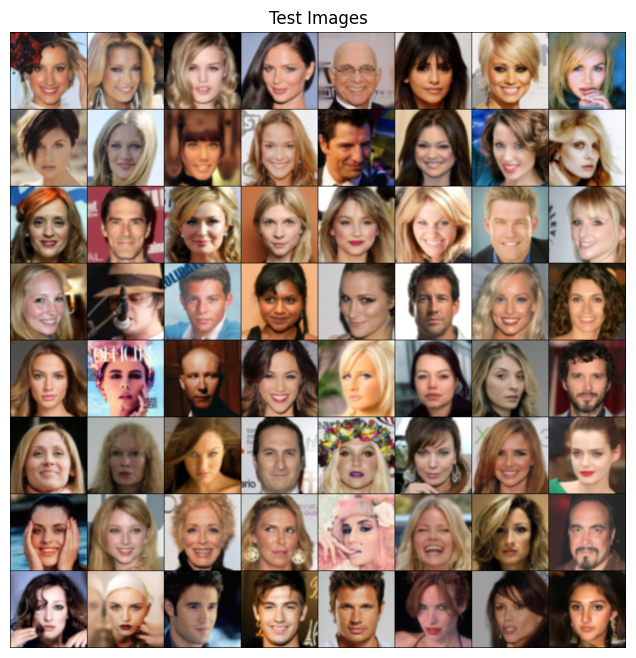

In [18]:
real_batch = next(iter(test_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][2][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

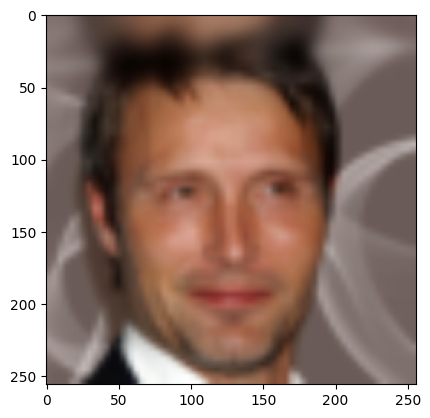

In [21]:
grid_ex = torchvision.utils.make_grid(real_batch[0][2][120], padding=2, normalize=True)
plt.imshow(grid_ex.permute(1,2,0))
plt.show

## Set the device and load clip model.

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clip_model, _ = clip.load(f"ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 63.7MiB/s]


## Input the prompt that you want to generate and the epoch number that you stop the training.

In [23]:
text = str(input("Prompt : "))
load_epoch = int(input("Epoch we will load : "))

Prompt : The woman is young and has blond hair, and arched eyebrows.
Epoch we will load : 3


## Let's see the images that you generate.

In [24]:
# seed_fix(40)
hyp = torch.load(os.path.join('./model_exp1', f"hyperparameter.pt"), map_location='cpu')


G = Generator(hyp['clip_embedding_dim'], hyp['projection_dim'], hyp['noise_dim'], hyp['g_in_chans'], hyp['g_out_chans'], hyp['num_stage'], device).to(device)
D_lst = [
        Discriminator(hyp['projection_dim'], hyp['g_out_chans'], hyp['d_in_chans'], hyp['d_out_chans'], hyp['clip_embedding_dim'], curr_stage, device).to(device)
        for curr_stage in range(hyp['num_stage'])
    ]
load_checkpoint(G, D_lst, './model_exp1', load_epoch) # epoch 숫자 바꿔서 모델 쓸 것

prompt = clip.tokenize([text]).to(device)
txt_feature = clip_model.encode_text(prompt)
z = torch.randn(txt_feature.shape[0], hyp['noise_dim']).to(device)
txt_feature = normalize(txt_feature.to(device)).type(torch.float32)

fake_images, _, _ = G(txt_feature, z)
fake_image_64 = denormalize_image(fake_images[-3].detach().cpu())
fake_image_128 = denormalize_image(fake_images[-2].detach().cpu())
fake_image_256 = denormalize_image(fake_images[-1].detach().cpu())


<function matplotlib.pyplot.show(close=None, block=None)>

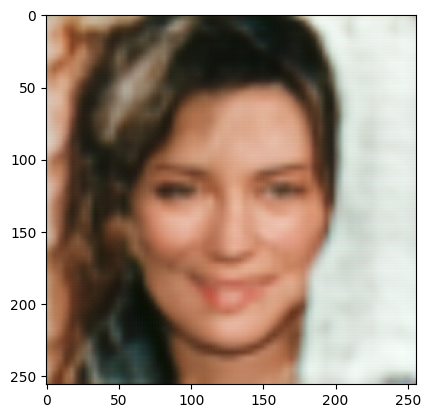

In [25]:
grid = torchvision.utils.make_grid(fake_image_256, padding=2, normalize=True)
plt.imshow(grid.permute(1,2,0))
plt.show

## Generate several images for evaluation with test data, in the amount of the batch size.

In [26]:
def generate_images_batch(batch_size):
  fake_image_list = []
  for _ in range(batch_size):
    prompt = clip.tokenize([text]).to(device)
    txt_feature = clip_model.encode_text(prompt)
    z = torch.randn(txt_feature.shape[0], hyp['noise_dim']).to(device)
    txt_feature = normalize(txt_feature.to(device)).type(torch.float32)

    fake_images, _, _ = G(txt_feature, z)
    fake_image_256 = denormalize_image(fake_images[-1].detach().cpu())
    fake_image_list.append(fake_image_256.squeeze(0))
  fake_image_stacked = torch.stack(fake_image_list, dim=0)
  return fake_image_stacked

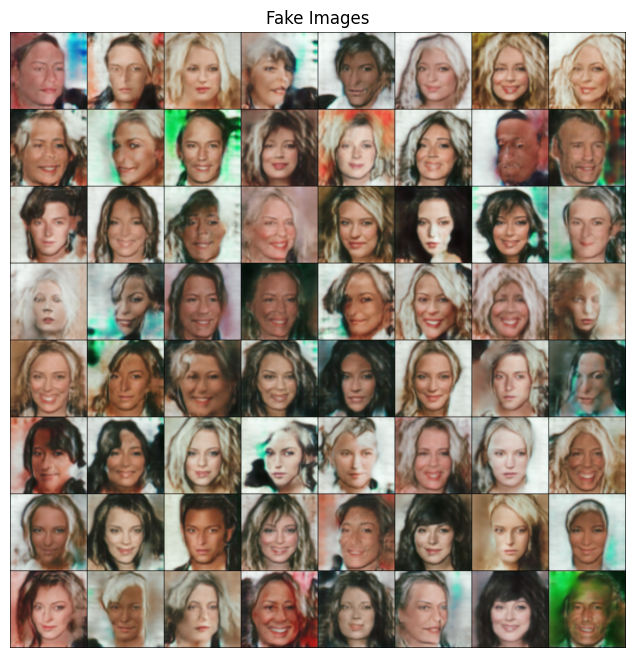

In [27]:
fake_batch = generate_images_batch(128)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_batch[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [28]:
fake_batch.shape

torch.Size([128, 3, 256, 256])

## Let's measure FID and IS using the two prepared datasets.

In [29]:
from ignite.metrics import FID, InceptionScore

In [30]:
fid_metric = FID(device=idist.device())

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 177MB/s] 


In [31]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

In [32]:
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

In [33]:
def evaluation_step(engine, batch):
    with torch.no_grad():
        fake_batch = generate_images_batch(128)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0][2])
        return fake, real

In [34]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [35]:
evaluator.run(test_dataloader,max_epochs=1) # This code will take quite some time to execute.

State:
	iteration: 46
	epoch: 1
	epoch_length: 46
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [36]:
metrics = evaluator.state.metrics

In [37]:
fid_score = metrics['fid']
is_score = metrics['is']

In [38]:
print(f"*   FID : {fid_score:4f}")
print(f"*    IS : {is_score:4f}")

*   FID : 0.244888
*    IS : 1.870282
